In [4]:
from bs4 import BeautifulSoup as bs
import pandas as pd
import requests
import json
import csv
import os
from dotenv import load_dotenv
import google.generativeai as genai
from sacrebleu.metrics import BLEU
from rouge import Rouge
import matplotlib.pyplot as plt
import tiktoken
from google.generativeai.types import HarmCategory, HarmBlockThreshold

load_dotenv('../.env')

True

### Exercício 4

In [5]:
HEADER = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
    }

In [6]:
resp = requests.get("https://tecnoblog.net/noticias/page/1", headers=HEADER, timeout=30)
soup = bs(resp.content, 'html.parser')
manchetes = [h2.get_text('h2') for h2 in soup.select("h2")]
# Havia um erro na captura das manchetes, portanto foi necessário remover o h2 'Mais Populares'
for manchete in manchetes:
    if manchete == 'Mais Populares':
        manchetes.remove(manchete)
#manchetes

In [7]:
exemplos = {
    "positivos" : [
        "5 dicas para melhorar a imagem em TVs de alta definição",
        "Mafalda visita sede da ONU, ganha crachá e realiza sonho",
        "Trump escolhe general para missão de encerrar guerra na Ucrânia"
    ] ,
    "negativos" : [
        'Chuva torrencial em Salvador causa deslizamentos e deixa 1 morto',
        "3 mulheres são presas por venda de remédio pirata para emagrecer",
        "Idoso sofre golpe da 'namorada virtual investidora' e perde R$ 2 milhões"
    ],
    "neutros" : [
        "iFood anuncia mudança no código de entrega; saiba como vai funcionar",
        "Filmes sobre os Beatles terá Barry Keoghan como Ringo Starr",
        "Oscar 2025: quais filmes estão na disputa com 'Ainda Estou Aqui'"
    ],
}

prompt = f"""
Você é um especialista em comunicação e jornalismo especializado em análise de sentimentos.
Você foi contratado para classificar manchetes de notícias em positivas, negativas ou neutras, de acordo com os exemplos:

#Positivos: {exemplos['positivos']}

#Negativos: {exemplos['negativos']}

#Neutros: {exemplos['neutros']}

Dado o contexto, responda em formato JSON a classificação das manchetes, a seguir em Positiva, Negativa ou Neutra, individualmente:

{manchetes}

"""

In [8]:
genai.configure(api_key=os.environ["GEMINI_KEY"])
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt)
print(response.text)

```json
{
  "manchetes": [
    {
      "manchete": "Venda da Oi Fibra para rede neutra V.tal é aprovada pelo Cade",
      "classificacao": "Neutra"
    },
    {
      "manchete": "Navio chinês é suspeito de sabotar cabos submarinos de internet",
      "classificacao": "Negativa"
    },
    {
      "manchete": "Moto AI: Motorola libera teste de novas funções de IA no celular",
      "classificacao": "Positiva"
    },
    {
      "manchete": "Startup de supermercado Justo vai suspender operações no Brasil",
      "classificacao": "Negativa"
    },
    {
      "manchete": "OpenAI suspende acesso após artistas vazarem gerador de vídeos da empresa",
      "classificacao": "Negativa"
    },
    {
      "manchete": "iFood anuncia mudança no código de entrega",
      "classificacao": "Neutra"
    },
    {
      "manchete": "TikTok vai proibir que menores de 18 anos usem filtros de aparência",
      "classificacao": "Neutra"
    },
    {
      "manchete": "Raspberry Pi Compute Module 5 chega co

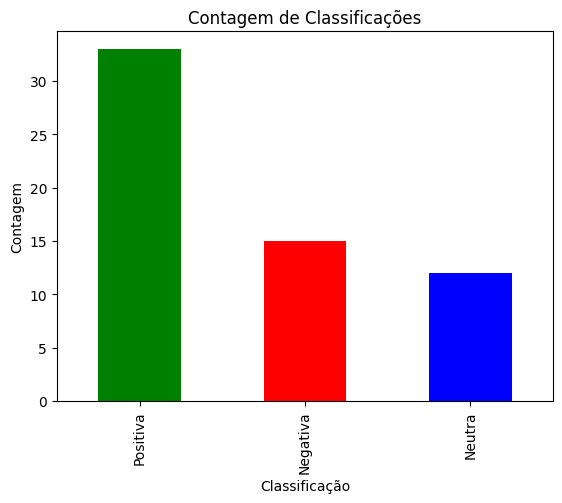

In [9]:
classif = json.loads(response.text.replace("```json\n",'').replace("\n```",''))
classif = pd.DataFrame(classif['manchetes'])
classif.columns = ['Manchete', 'Classificação']

classif_counts = classif['Classificação'].value_counts()

classif_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.xlabel('Classificação')
plt.ylabel('Contagem')
plt.title('Contagem de Classificações')
plt.show()

### Exercício 5

In [10]:
df_script = pd.read_csv('../data/simpsons_script_lines.csv', low_memory=False)
df_episodes = pd.read_csv('../data/simpsons_episodes.csv', low_memory=False)
df_characters = pd.read_csv('../data/simpsons_characters.csv', low_memory=False)
df_locations = pd.read_csv('../data/simpsons_locations.csv', low_memory=False)

df_script.set_index('id', inplace=True)
df_characters['id'] = df_characters['id'].astype(str)

df_characters = df_characters.add_prefix('character_')
df_locations = df_locations.add_prefix('location_')
df_episodes = df_episodes.add_prefix('episode_')

data = (
    df_script.merge(df_episodes, left_on='episode_id', right_on='episode_id')
             .merge(df_characters, left_on='character_id', right_on='character_id', how='left')
             .merge(df_locations, left_on='location_id', right_on='location_id', how='left')
)

assert data.shape[0] == df_script.shape[0]

In [11]:
data.head().T

,0,1,2,3,4
episode_id,32,32,32,32,32
number,209,210,211,212,213
raw_text,"Miss Hoover: No, actually, it was a little of ...",Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,Miss Hoover: I don't know. Although I'd sure l...,Lisa Simpson: That life is worth living.,Edna Krabappel-Flanders: The polls will be ope...
timestamp_in_ms,848000,856000,856000,864000,864000
speaking_line,true,true,true,true,true
character_id,464,9,464,9,40
location_id,3.0,3.0,3.0,3.0,3.0
raw_character_text,Miss Hoover,Lisa Simpson,Miss Hoover,Lisa Simpson,Edna Krabappel-Flanders
raw_location_text,Springfield Elementary School,Springfield Elementary School,Springfield Elementary School,Springfield Elementary School,Springfield Elementary School
spoken_words,"No, actually, it was a little of both. Sometim...",Where's Mr. Bergstrom?,I don't know. Although I'd sure like to talk t...,That life is worth living.,The polls will be open from now until the end ...


In [12]:
def estimar_tokens(texto):
    encoder = tiktoken.get_encoding("cl100k_base")
    tokens = encoder.encode(texto)
    return tokens

In [13]:
X = data.dropna(subset='normalized_text').copy()
X['n_tokens'] = X.normalized_text.fillna('').apply(lambda x: len(estimar_tokens(x)))

In [14]:
X.groupby('episode_id').n_tokens.sum()

media_tokens_ep = X.groupby('episode_id').n_tokens.sum().mean()
max_token_ep = X.groupby('episode_id').n_tokens.sum().max()

X.groupby('episode_season').n_tokens.sum()

media_tokens_temp = X.groupby('episode_season').n_tokens.sum().mean()
max_token_temp = X.groupby('episode_season').n_tokens.sum().max()

In [15]:
print(f"Média de Tokens por Episódio: {media_tokens_ep}")
print(f"Episódio com o maior número de Tokens: {max_token_ep}")
print(f"Média de Tokens por Temporada: {media_tokens_temp}")
print(f"Temporada com o maior número de Tokens: {max_token_temp}")

Média de Tokens por Episódio: 2606.982269503546
Episódio com o maior número de Tokens: 3454
Média de Tokens por Temporada: 56551.46153846154
Temporada com o maior número de Tokens: 70418


In [16]:
grouped_by_rating = X.groupby('episode_imdb_rating')

grouped_by_views = X.groupby('episode_views')

In [17]:
prompt = f"""
You are an expert in analysing the response to TV series episodes.
You have been now tasked with analysing the IMDB rating and views of the episodes of 'The Simpsons'.
You have been given the following tables:

# IMDB Ratings grouped:
{grouped_by_rating.size()}

# Views per episode:
{grouped_by_views.size()}

The tables contain the IMDB ratings and views of the episodes of 'The Simpsons'.
You should make a critic and descriptive analysis of the data, and provide a conclusion about the quality of the episodes.
"""

In [18]:
genai.configure(api_key=os.environ["GEMINI_KEY"])
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt)
print(response.text)

## Analysis of The Simpsons Episode Ratings and Views

The provided data offers a glimpse into the reception of The Simpsons episodes, but suffers from limitations that prevent definitive conclusions about overall episode quality.  Let's break down the analysis:

**I. IMDB Rating Analysis:**

The `episode_imdb_rating` data shows a distribution of IMDB ratings.  Critically, this data is *grouped*, meaning we only know the *count* of episodes at each rating, not the specific ratings of individual episodes. This limits our ability to perform certain statistical analyses.  

* **Distribution:** The distribution is heavily skewed towards the 6.0-7.5 range, suggesting a concentration of episodes with average to above-average ratings.  A significant number of episodes fall into the 6.5-7.2 range, indicating a large cluster of episodes with relatively consistent positive reception.  The tails of the distribution show fewer episodes with extremely high or low ratings.

* **High-Rating Episodes:

In [19]:
first_analysis = response.text
new_prompt = f"""
You are an expert in analysing the response to TV series episodes.
You have been now tasked with analysing the IMDB rating and views of the episodes of 'The Simpsons'.
You have been given the following tables:

# IMDB Ratings grouped:
{grouped_by_rating.size()}

# Views per episode:
{grouped_by_views.size()}

The tables contain the IMDB ratings and views of the episodes of 'The Simpsons'.
You should review a pre made critic and descriptive analysis of the data, and provide your own insight.
Here is the previous analysis:

{first_analysis}
"""

In [20]:
genai.configure(api_key=os.environ["GEMINI_KEY"])
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(new_prompt)
print(response.text)

The previous analysis correctly identifies the limitations of the provided data and highlights the crucial need for merging the datasets, visualization, and further statistical analysis.  I agree with its cautious conclusions and the suggested improvements. However, I can offer some additional insights based on the existing, albeit limited, data:

**Further Insights Based on Existing Data:**

* **IMDB Rating Skew:** The strong skew in the IMDB rating data towards the 6.0-7.5 range, while suggesting generally positive reception, also hints at a potential ceiling effect. This could indicate that the IMDB rating system might not be perfectly calibrated to capture the full range of quality in a show with such a long and varied history. A highly rated episode might not receive a significantly higher rating than a moderately well-received one simply due to the limitations of the scale and the inherent subjectivity of ratings.

* **Viewership Variability:** The wide range in episode views (15

### Exercício 6

In [21]:
positivas = [
    "that life is worth living",
    "i am the champions i am the champions no time for losers cause i am the champions of the worlllld",
    "eh you must be bart simpson well you look like youve got a strong young back",
    "its so nice to finally meet you",
    "you know it's been a nice week",
]

negativas = [
    "i dont think theres anything left to say",
    "we came to this retreat because i thought our marriage was in trouble but i never for a minute thought it was in this much trouble homer how can you expect me to believe",
    "oh thats my brother asa he was killed in the great war held a grenade too long",
    "yeah thats my ex husbands room oh how i miss him",
    "oh i dont know i think i might be a little rusty",
]

neutras = [
    "wheres mr bergstrom",
    "would you have to do extra work",
    "oh please dad i want this more than anything in the world",
    "id like a burger please",
    "hm im not sure"
]

In [22]:
episode_season = 5
episode_id = 92
X = (data[(data.episode_season == episode_season) &
          (data.episode_id == episode_id)].sort_values('number')
)
X = X.dropna(subset='normalized_text')

prompt = f"""
You are an expert in human communication and marketing, specialized in sentiment analysis.
You have to classify lines from a cartoon show as negative, neutral and positive as defined below:
- positive: happy, constructive, hopefull, joy and similar lines.
- negative: sad, destructive, hopeless, angressive and similar lines.
- neutral: indifferent, objetive, formal and lines classified neigher as positive or negative.

Some pre-classified lines from this show are listed here:

# Positive:
{ '- '.join(positivas) }


# Negative:
{ '- '.join(negativas) }


# Neutral:
{ '- '.join(neutras) }

Given this information, respond in JSON with the classification of these other lines as positive, negative or neutral.


{ '- '.join(X.normalized_text.tolist()[:100]) }

"""

In [39]:
genai.configure(api_key=os.environ["GEMINI_KEY"])
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt)
print(response.text)

```json
{
  "classifications": [
    {
      "line": "dad weve been robbed",
      "sentiment": "negative"
    },
    {
      "line": "wake up dad wake up there was a burglar and he took my saxophone",
      "sentiment": "negative"
    },
    {
      "line": "woo hoo",
      "sentiment": "positive"
    },
    {
      "line": "and our portable tv",
      "sentiment": "negative"
    },
    {
      "line": "and my necklace",
      "sentiment": "negative"
    },
    {
      "line": "eh thats no big loss",
      "sentiment": "neutral"
    },
    {
      "line": "homer that necklace was a priceless bouvier family heirloom",
      "sentiment": "negative"
    },
    {
      "line": "oh youve probably got a whole drawer full of em",
      "sentiment": "neutral"
    },
    {
      "line": "well yes i do but theyre all heirlooms too",
      "sentiment": "neutral"
    },
    {
      "line": "the burglar even took my stamp collection",
      "sentiment": "negative"
    },
    {
      "line": "you h

<Axes: xlabel='# falas', ylabel='Sentimento'>

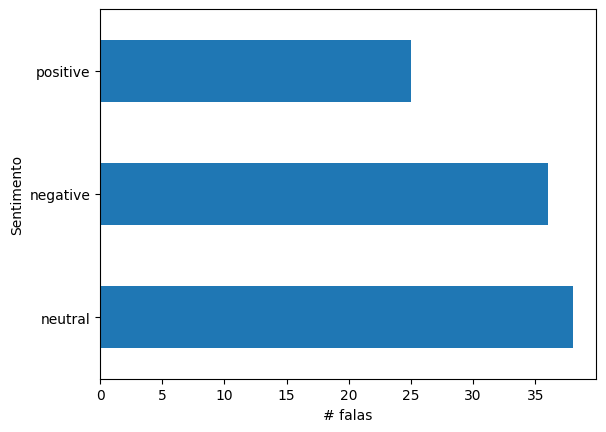

In [40]:
sentiments = json.loads(response.text.replace("```json\n",'').replace("\n```",''))
sentiments = pd.DataFrame(sentiments["classifications"])
sentiments.columns = ['normalized_text', 'sentiment']
sentiments.sentiment.value_counts().plot.barh(xlabel='# falas', ylabel='Sentimento')

### Exercício 7

In [51]:
resumo = "A man invades the Simpsons’ house and steals Lisa’s saxophone, Bart’s portable TV, Marge’s necklace and more. The family discusses the stolen goods and finds a card indicating they were robbed by The Springfield Cat Burglar. Other characters appear angry for also being robbed. The citizens begin installing high-tech security in their houses and seem very shaken by the burglar. Lisa is very sad and misses her saxophone, this moves Homer. Flanders tries creating a vigilante team, and Homer becomes the leader. The people arm themselves and prepare to go on missions. They try to solve crimes around the city but mainly fail. Homer is being interviewed and the burglar calls to tell everyone he will rob the Springfield Museum. The vigilantes patrol the museum but fail to protect it. Everyone appears protesting against Homer. Homer’s father tells the family he discovered the burglar lives with him in the Retirement Home and his name is Molloy. The citizens confront Molloy. He gives back the stolen items and the people forgive him. He gets arrested and tells everyone he buried millions of dollars in a T shaped tree. Everyone runs to find it, but fails. They find a note in which Molloy says there is no treasure and he escaped prison. Homer keeps searching and finds nothing."
tokens = estimar_tokens(resumo)
print(len(tokens))

259


### Exercício 8

In [28]:
class ChunkSummary():
    def __init__(self, model_name, apikey, text, window_size, overlap_size):
        self.text = text
        if isinstance(self.text, str):
            self.text = [self.text]
        self.window_size = window_size
        self.overlap_size = overlap_size
        # Aplicacao dos chunks
        self.chunks = self.__text_to_chunks()
        self.model = self.__create_model(apikey, model_name)

    def __create_model(self, apikey, model_name):
        genai.configure(api_key=apikey)
        self.prompt_base = f"""
        You are an editor assistant from the "The Simpsons" show.
        You will receive the #subtitles# from real episodes in the format:
        <location>, <character> said: <character line>
        
        You must create a summary of the #subtitles#, pointing out the most
        relevant information, jokes and key players in the story. Bare in mind
        that the summary must describe how the episode started, which key
        points are relevant along the story and its gran finale.
        The summary output must be written as a plain JSON with field 'summary'.
        """
        safety_settings={
            HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
        }
        generation_config = {
            'temperature': 0.2,
            'top_p': 0.8,
            'top_k': 20,
            'max_output_tokens': 1000
        }
        return genai.GenerativeModel(
            model_name,
            system_instruction=self.prompt_base,
            generation_config = generation_config,
            safety_settings=safety_settings
        )
    
    def __text_to_chunks(self):       
        n = self.window_size  # Tamanho de cada chunk
        m = self.overlap_size  # overlap entre chunks
        return [self.text[i:i+n] for i in range(0, len(self.text), n-m)]


    def __create_chunk_prompt(self, chunk):
        episode_lines = '\n'.join(chunk)
        prompt = f"""
        #subtitles#
        {episode_lines}
        ######
        Summarize it.
        """
        return prompt
    
    def __summarize_chunks(self):
        # Loop over chunks
        chunk_summaries = []
        for i, chunk in enumerate(self.chunks):
            print(f'Summarizing chunk {i+1} from {len(self.chunks)}')
            # Create prompt
            prompt = self.__create_chunk_prompt(chunk)
            response = self.model.generate_content(prompt)
            # Apendar resposta do chunk
            chunk_summaries.append(response.text)

        return chunk_summaries

    def summarize(self):
        print('Summarizing text')
        # Chamar o sumario dos chunks
        self.chunk_summaries = self.__summarize_chunks()
        # Prompt final
        summaries = '- ' + '\n- '.join(self.chunk_summaries)
        prompt = f"""
        You are an editor working on The Simpsons show. You must summarize
        a show episode considering the other summaries from part of the episode.
        The partitioned summaries are listed below:
        {summaries}
        ######
        The summary must describe the details in the story, like jokes, and details
        on what happens in the end with the key characters.
        Write a final summary based on the partitioned summaries in JSON format with
        the field 'summary'
        """
        print('Final summarization')
        response = self.model.generate_content(prompt)
        
        return response.text

In [29]:
episode_season = 5
episode_id = 92
X = (data[(data.episode_season == episode_season) &
          (data.episode_id == episode_id)].sort_values('number')
)

X['line'] = (X['location_normalized_name'].fillna('') + ', ' + 
             X['character_normalized_name'].fillna('') + ' said: ' + 
             X['normalized_text'].fillna('')
)

summarizer = ChunkSummary(
    model_name = "gemini-1.5-flash",
    apikey = os.environ["GEMINI_KEY"],
    text = X['line'].tolist(),
    window_size = 100,
    overlap_size = 25
)

episode_summary = summarizer.summarize()

Summarizing text
Summarizing chunk 1 from 4
Summarizing chunk 2 from 4
Summarizing chunk 3 from 4
Summarizing chunk 4 from 4
Final summarization


In [48]:
final_summmary = json.loads(episode_summary.replace("```json\n",'').replace("\n```",''))
final_summmary["summary"]

"The episode begins with a series of burglaries in Springfield, targeting the Simpsons' home and many others.  Lisa's saxophone and other valuables are stolen by the elusive Cat Burglar.  Chief Wiggum's investigation is utterly inept, leading to the formation of a neighborhood watch led by the hilariously incompetent Homer Simpson.  Homer's ragtag group, including Moe, Skinner, Barney, and even Grampa, causes more chaos than it prevents, engaging in over-the-top violence and generally making things worse.  The Cat Burglar, revealed to be Molloy, a resident of the Springfield Retirement Castle, taunts Homer on live television.  Grampa, surprisingly, uses his sharp observation skills to identify Molloy, leading to his arrest.  However, the episode's humor lies in the absurdity of Springfield's justice system, as Molloy is ultimately released due to a bribe paid to Chief Wiggum by Mayor Quimby.  The episode is filled with slapstick comedy, witty dialogue, and satirical commentary on polic

In [46]:
chunk_0 = json.loads(summarizer.chunk_summaries[0].replace("```json\n",'').replace("\n```",''))
chunk_1 =  json.loads(summarizer.chunk_summaries[1].replace("```json\n",'').replace("\n```",''))
chunk_2 = json.loads(summarizer.chunk_summaries[2].replace("```json\n",'').replace("\n```",''))
chunk_3 = json.loads(summarizer.chunk_summaries[3].replace("```json\n",'').replace("\n```",''))
print(chunk_0["summary"])
print(chunk_1["summary"])
print(chunk_2["summary"])
print(chunk_3["summary"])

The Simpsons' home is robbed by the Springfield Cat Burglar, who steals Lisa's saxophone, Bart's stamp collection, and Marge's necklace.  Homer is unconcerned, but the family discovers many of their neighbors have also been targeted.  Chief Wiggum's inept investigation leads nowhere, despite a seemingly obvious clue pointing to the police station itself.  Professor Frink offers a bizarre explanation of the burglar's high-tech escape method.  The robbery causes widespread panic, with even the Springfield Retirement Castle residents fearing for their safety.  After failing to get insurance due to Homer's poor decision-making (buying magic beans instead), the Simpsons implement new security measures.  Homer, however, vows to get Lisa's saxophone back.  The episode culminates with the formation of a neighborhood watch, hilariously led by Homer, who recruits a ragtag group of Springfield residents, including Moe, Apu, Skinner, and even Grampa (despite Homer's initial dismissal of the elderl

### Exercício 9

In [66]:
bleu_scorer = BLEU()

def bleu(hyp, ref):
    score = bleu_scorer.sentence_score(
        hypothesis=hyp,
        references=[ref],
    )
    return score.score/100

rouge_scorer = Rouge()

def rouge(hyp, ref):
    score = rouge_scorer.get_scores(
        hyps=hyp,
        refs=ref
        )
    return {
        'ROUGE-L-F': score[0]["rouge-l"]["f"],
        'ROUGE-L-R': score[0]["rouge-l"]['r'],
        'ROUGE-L-P': score[0]["rouge-l"]['p'],
    }

In [68]:
print()
print("# Resumos Completos")
print("BLEU =", bleu(final_summmary["summary"], resumo))
print(rouge(final_summmary["summary"], resumo))
print()
print("# Primeiro Chunk")
print("BLEU =", bleu(chunk_0["summary"], resumo))
print(rouge(chunk_0["summary"], resumo))
print()
print("# Segundo Chunk")
print("BLEU =", bleu(chunk_1["summary"], resumo))
print(rouge(chunk_1["summary"], resumo))
print()
print("# Terceiro Chunk")
print("BLEU =", bleu(chunk_2["summary"], resumo))
print(rouge(chunk_2["summary"], resumo))
print()
print("# Quarto Chunk")
print("BLEU =", bleu(chunk_3["summary"], resumo))
print(rouge(chunk_3["summary"], resumo))

It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.



# Resumos Completos
BLEU = 0.02133354773795271
{'ROUGE-L-F': 0.15282391528172998, 'ROUGE-L-R': 0.1619718309859155, 'ROUGE-L-P': 0.14465408805031446}

# Primeiro Chunk
BLEU = 0.02338109533494551
{'ROUGE-L-F': 0.16479400251090645, 'ROUGE-L-R': 0.15492957746478872, 'ROUGE-L-P': 0.176}

# Segundo Chunk
BLEU = 0.01344520486753109
{'ROUGE-L-F': 0.1804511228424446, 'ROUGE-L-R': 0.16901408450704225, 'ROUGE-L-P': 0.1935483870967742}

# Terceiro Chunk
BLEU = 0.013125034974273064
{'ROUGE-L-F': 0.15613382401182974, 'ROUGE-L-R': 0.14788732394366197, 'ROUGE-L-P': 0.16535433070866143}

# Quarto Chunk
BLEU = 0.011919297954018524
{'ROUGE-L-F': 0.1935483822021333, 'ROUGE-L-R': 0.16901408450704225, 'ROUGE-L-P': 0.22641509433962265}


### Exercício 10

In [71]:
sentiments.to_csv('../data/sentiments.csv', index=False)

In [74]:
with open('../data/sentiments.csv') as sents:
    reader = csv.DictReader(sents)
    dialog_sentiments = []
    for row in reader:
        dialog_sentiments.append(row)